In [13]:
# Quoridor Game with MCTS Implementation
# This module implements the Quoridor board game for two players, including Monte Carlo Tree Search (MCTS) for AI moves.
# The game supports pawn movement and wall placement, with a graphical policy visualization.


# Module 1: Game State Management
"""
Module 1: GameState
Purpose: Manages the state of the Quoridor game, including player positions, walls, and the game board.
Key Features:
- Initializes the game board with a given size and number of walls.
- Encodes the game state for AI processing.
- Provides a method to create a copy of the current state.
- Represents the board as a 2D array where:
  - 0: Empty path
  - 1: Wall
  - 2: Player 1
  - 3: Player 2
"""

In [14]:
class GameState:
    def __init__(self, size: int = 9, wall_count: int = 10, copy_state: 'GameState' = None):
        self.size = size
        if copy_state:
            self.size = copy_state.size
            self.player_positions = copy_state.player_positions.copy()
            self.remaining_walls = copy_state.remaining_walls.copy()
            self.wall_grid = copy_state.wall_grid.copy()
            self.game_board = copy_state.game_board.copy()
            self.turn_count = copy_state.turn_count
        else:
            self.player_positions = np.array([[0, size // 2], [size - 1, size // 2]])
            self.remaining_walls = np.array([wall_count, wall_count])
            self.wall_grid = np.zeros((2, size - 1, size - 1), dtype=np.int8)
            self.game_board = self._create_board()
            self.turn_count = 0

    def _create_board(self):
        """Initializes a 2N-1 x 2N-1 board with walls and player positions."""
        board = np.zeros((self.size * 2 - 1, self.size * 2 - 1), dtype=np.int8)
        board[1::2, 1::2] = 1  # Wall intersections
        board[self.player_positions[0, 0] * 2, self.player_positions[0, 1] * 2] = 2  # Player 1
        board[self.player_positions[1, 0] * 2, self.player_positions[1, 1] * 2] = 3  # Player 2
        return board

    def duplicate(self):
        """Creates a deep copy of the current game state."""
        return GameState(copy_state=self)

    def encode_state(self, player):
        """
        Encodes the game state into a 4xNxN array for AI input.
        Channels:
        - 0: Current player's position
        - 1: Opponent's position
        - 2: Horizontal walls
        - 3: Vertical walls
        Flips the board vertically for player 1.
        """
        encoded = np.zeros((4, self.size, self.size), dtype=np.float32)
        encoded[player, self.player_positions[0, 0], self.player_positions[0, 1]] = 1
        encoded[1 - player, self.player_positions[1, 0], self.player_positions[1, 1]] = 1
        if player == 1:
            encoded[:2, :, :] = np.flip(encoded[:2, :, :], axis=1)
        wall_1 = self.wall_grid[0, :, :] if player == 0 else np.flipud(self.wall_grid[1, :, :])
        wall_2 = self.wall_grid[1, :, :] if player == 0 else np.flipud(self.wall_grid[0, :, :])
        encoded[2, :, :] = np.pad(wall_1 == 1, ((0, 1), (0, 1)), 'constant')
        encoded[3, :, :] = np.pad(wall_2 == 1, ((0, 1), (0, 1)), 'constant')
        return encoded

# Module 2: Game Rules and Logic
"""
Module 2: QuoridorGame
Purpose: Implements the rules and mechanics of the Quoridor game.
Key Features:
- Validates moves and wall placements.
- Calculates the shortest path to the goal using A* algorithm.
- Manages game state transitions and win conditions.
- Provides valid actions for the current player.
"""

In [15]:

class QuoridorGame:
    def __init__(self, board_size, total_walls):
        self.board_size = board_size
        self.total_walls = total_walls

    def new_game(self):
        """Returns the initial game state."""
        return GameState(self.board_size, self.total_walls)

    def _find_shortest_path(self, state: GameState, player):
        """
        Uses A* algorithm to find the shortest path to the goal.
        Returns the distance or -1 if no path exists.
        Heuristic: Manhattan distance to the goal row.
        """
        board = state.game_board
        start = state.player_positions[player] * 2
        priority_queue = [(2 * self.board_size - 2, 0, 0, start)]
        visited = np.zeros((2 * self.board_size - 1, 2 * self.board_size - 1), dtype=np.int8)
        counter = 0
        while priority_queue:
            _, _, steps, pos = heapq.heappop(priority_queue)
            if pos[0] < 0 or pos[0] > 2 * self.board_size - 2 or pos[1] < 0 or pos[1] > 2 * self.board_size - 2:
                continue
            if board[*pos] == 1 or visited[*pos] == 1:
                continue
            if pos[0] == (2 * self.board_size - 2) * (1 - player):
                return steps
            visited[*pos] = 1
            for direction in [[-1, 0], [1, 0], [0, -1], [0, 1]]:
                new_pos = pos + direction
                heuristic = (2 * self.board_size - 2 - new_pos[0]) * (1 - player) + (2 * new_pos[0]) * player
                heapq.heappush(priority_queue, (heuristic + steps + 1, counter := counter + 1, steps + 1, new_pos))
        return -1

    def is_wall_valid(self, state: GameState):
        """Checks if walls allow a path to the goal for both players."""
        return self._find_shortest_path(state, 0) != -1 and self._find_shortest_path(state, 1) != -1

    def _get_possible_moves(self, state: GameState, player):
        """
        Uses DFS to find valid moves (up to 2 steps, including jumps).
        Returns a list of valid positions.
        """
        board = state.game_board
        current_pos = state.player_positions[player] * 2
        valid_moves = []
        stack = [(current_pos, 0)]
        visited = np.zeros((2 * self.board_size - 1, 2 * self.board_size - 1), dtype=np.int8)
        while stack:
            pos, steps = stack.pop()
            if pos[0] < 0 or pos[0] > 2 * self.board_size - 2 or pos[1] < 0 or pos[1] > 2 * self.board_size - 2:
                continue
            if board[*pos] == 1 or visited[*pos] == 1:
                continue
            if board[*pos] in [2, 3]:
                steps = 0
            visited[*pos] = 1
            if steps == 2:
                valid_moves.append(pos // 2)
                continue
            for direction in [[-1, 0], [1, 0], [0, -1], [0, 1]]:
                stack.append((pos + direction, steps + 1))
        return valid_moves

    def is_move_valid(self, state: GameState, target_pos, player):
        """Checks if a move to target_pos is valid."""
        return any(np.array_equal(target_pos, move) for move in self._get_possible_moves(state, player))

    def apply_action(self, state: GameState, action: tuple, player: int):
        """
        Applies an action (move or wall placement) and returns the new state.
        Returns None if the action is invalid.
        """
        action_type, row, col = action
        new_state = state.duplicate()
        new_state.turn_count += 1
        if action_type == 0:  # Move
            if self.is_move_valid(new_state, (row, col), player):
                new_state.game_board[*new_state.player_positions[player] * 2] = 0
                new_state.game_board[row * 2, col * 2] = player + 2
                new_state.player_positions[player] = (row, col)
                return new_state
            return None
        else:  # Wall
            if new_state.remaining_walls[player] == 0:
                return None
            orientation = action_type - 1
            if new_state.wall_grid[orientation, row, col] != 0:
                return None
            new_state.wall_grid[orientation, row, col] = 1
            new_state.wall_grid[1 - orientation, row, col] = -1
            if orientation == 0 and col > 0:
                new_state.wall_grid[0, row, col - 1] = -1
            if orientation == 1 and row > 0:
                new_state.wall_grid[1, row - 1, col] = -1
            if orientation == 0 and col < self.board_size - 2:
                new_state.wall_grid[0, row, col + 1] = -1
            if orientation == 1 and row < self.board_size - 2:
                new_state.wall_grid[1, row + 1, col] = -1
            new_state.game_board[
                row * 2 - orientation + 1 : row * 2 + orientation + 2,
                col * 2 - (1 - orientation) + 1 : col * 2 + (1 - orientation) + 2
            ] = 1
            new_state.remaining_walls[player] -= 1
            if not self.is_wall_valid(new_state):
                return None
            return new_state

    def get_available_actions(self, state: GameState, player: int):
        """Returns a 3xNxN array of valid actions (moves and walls)."""
        moves = self._get_possible_moves(state, player)
        walls = [
            (hv, r, c)
            for hv in range(2)
            for r in range(self.board_size - 1)
            for c in range(self.board_size - 1)
            if self.apply_action(state, (hv + 1, r, c), player) is not None
        ]
        actions = np.zeros((3, self.board_size, self.board_size))
        for move in moves:
            actions[0, *move] = 1
        for hv, r, c in walls:
            actions[1 + hv, r, c] = 1
        return actions

    def has_won(self, state: GameState, player):
        """Checks if the player has reached their goal row."""
        return state.player_positions[player][0] == (self.board_size - 1) * (1 - player)

    def evaluate_draw(self, state: GameState, player: int):
        """
        Returns a heuristic value based on the shortest path lengths.
        Value = player's path length / (player's path length + opponent's path length).
        """
        player_path = self._find_shortest_path(state, player)
        opponent_path = self._find_shortest_path(state, 1 - player)
        return player_path / (player_path + opponent_path)

    def check_game_status(self, state: GameState, player: int):
        """
        Returns (is_terminal, is_draw, value) for the game state.
        Terminates after 50 moves or if a player wins.
        """
        if state.turn_count > 50:
            return True, True, self.evaluate_draw(state, player)
        if self.has_won(state, player):
            return True, False, 1
        return False, False, 0

"""
Module 3: SearchNode and MCTSSearch
Purpose: Implements the MCTS algorithm to select optimal moves.
Key Features:
- SearchNode: Represents a node in the MCTS tree, storing state, actions, and statistics.
- MCTSSearch: Runs MCTS iterations to evaluate actions and return action probabilities.
- Uses UCB formula for node selection.
- Simulates random rollouts to estimate values.
- Backpropagates results to update node statistics.
"""

In [16]:
class SearchNode:
    def __init__(self, game: QuoridorGame, config, state: GameState, player, parent=None, action=None):
        self.game = game
        self.config = config
        self.state = state
        self.player = player
        self.parent = parent
        self.action = action
        self.children = []
        self.available_actions = self.game.get_available_actions(self.state, self.player)
        self.visits = 0
        self.value_sum = 0

    def is_expanded(self):
        """Checks if all valid actions have been explored."""
        return np.sum(self.available_actions) == 0 and len(self.children) > 0

    def choose_child(self):
        """Selects the child node with the highest UCB score."""
        best_score = -np.inf
        best_child = None
        for child in self.children:
            score = self._calculate_ucb(child)
            if score > best_score:
                best_score = score
                best_child = child
        return best_child

    def _calculate_ucb(self, child):
        """Calculates the UCB score for a child node."""
        q_value = child.value_sum / child.visits
        exploration = self.config['C'] * math.sqrt(math.log(self.visits) / child.visits)
        return q_value + exploration

    def expand_node(self):
        """Expands the node by selecting a random valid action and creating a child."""
        action = random.choice(list(zip(*np.where(self.available_actions == 1))))
        self.available_actions[action] = 0
        child_state = self.game.apply_action(self.state, action, self.player)
        child = SearchNode(self.game, self.config, child_state, 1 - self.player, self, action)
        self.children.append(child)
        return child

    def rollout(self):
        """Performs a random simulation from the current state until termination."""
        current_state = self.state.duplicate()
        current_player = self.player
        while True:
            actions = self.game.get_available_actions(current_state, current_player)
            action = random.choice(list(zip(*np.where(actions == 1))))
            current_state = self.game.apply_action(current_state, action, current_player)
            is_terminal, is_draw, value = self.game.check_game_status(current_state, current_player)
            if is_terminal:
                return is_draw, value
            current_player = 1 - current_player

    def propagate(self, value, is_draw):
        """Updates node statistics and propagates the value up the tree."""
        self.visits += 1
        if is_draw:
            self.value_sum += value * self.config['draw_discount']
        else:
            self.value_sum += value
        if self.parent:
            self.parent.propagate(1 - value, is_draw)

class MCTSSearch:
    def __init__(self, game: QuoridorGame, config):
        self.game = game
        self.config = config

    def run_search(self, state, player):
        """Runs MCTS iterations and returns action probabilities."""
        root = SearchNode(self.game, self.config, state, player)
        for _ in tqdm.trange(self.config['n_searches']):
            node = root
            while node.is_expanded():
                node = node.choose_child()
            is_terminal, is_draw, value = self.game.check_game_status(node.state, 1 - node.player)
            if not is_terminal:
                node = node.expand_node()
                is_draw, value = node.rollout()
                value = 1 - value
            node.propagate(value, is_draw)
        action_probs = np.zeros((3, self.game.board_size, self.game.board_size), dtype=np.float32)
        for child in root.children:
            q_value = child.value_sum / child.visits
            visit_rate = child.visits / root.visits
            action_probs[*child.action] = q_value + math.sqrt(visit_rate) * 0.1
        action_probs /= np.sum(action_probs)
        return action_probs

In [17]:
import matplotlib.pyplot as plt


def plot_policy(policy, valid_actions, state: QuoridorState, player):
    if policy is None:
        policy = np.zeros((3, state.N, state.N))
    plt.figure(num=0)
    plt.axis()
    rect = plt.Rectangle((-0.5, -0.5), state.N, state.N, fc='w', ec='k')
    plt.gca().add_patch(rect)

    policy /= np.max(policy, axis=(0, 1, 2)) + 1e-8

    for i in range(state.N):
        for j in range(state.N):
            rate = float(policy[0, i, j])
            color = np.array([1-rate, 0, rate, 1]) if valid_actions[0, i, j] == 1 else 'w'
            rect = plt.Rectangle((i-0.3, j-0.3), 0.6, 0.6, fc=color, ec='k')
            plt.gca().add_patch(rect)

    for i in range(state.N - 1):
        for j in range(state.N - 1):
            rate = float(policy[1, i, j])
            color = 'k' if state.walls[0, i, j] == 1 else ('w' if valid_actions[1, i, j] == 0 else np.array([1-rate, 0, rate, 1]))
            rect = plt.Rectangle((i+0.5-0.1, j+0.5-0.5), 0.2, 1, fc=color, ec='k')
            plt.gca().add_patch(rect)

            rate = float(policy[2, i, j])
            color = 'k' if state.walls[1, i, j] == 1 else ('w' if valid_actions[2, i, j] == 0 else np.array([1-rate, 0, rate, 1]))
            rect = plt.Rectangle((i+0.5-0.5, j+0.5-0.1), 1, 0.2, fc=color, ec='k')
            plt.gca().add_patch(rect)

            rect = plt.Rectangle((i+0.5-0.1, j+0.5-0.1), 0.2, 0.2, fc='k', ec='k')
            plt.gca().add_patch(rect)



    circle = plt.Circle((state.positions[0, 0], state.positions[0, 1]), 0.1, fc='g' if player == 0 else 'w', ec='k')
    plt.gca().add_patch(circle)
    circle = plt.Circle((state.positions[1, 0], state.positions[1, 1]), 0.1, fc='g' if player == 1 else 'k', ec='k')
    plt.gca().add_patch(circle)

    plt.axis('scaled')
    plt.show()

In [18]:
# Module 4: Visualization
"""
Module 4: VisualizePolicy
Purpose: Visualizes the game board and policy probabilities for debugging and presentation.
Key Features:
- Displays the game board with player positions and walls.
- Colors valid moves and walls based on policy probabilities.
- Uses matplotlib to create a graphical representation.
"""
def visualize_policy(policy, valid_actions, state: GameState, player):
    if policy is None:
        policy = np.zeros((3, state.size, state.size))
    plt.figure()
    plt.axis()
    rect = plt.Rectangle((-0.5, -0.5), state.size, state.size, fc='w', ec='k')
    plt.gca().add_patch(rect)
    policy = policy / (np.max(policy) + 1e-8)
    for i in range(state.size):
        for j in range(state.size):
            intensity = float(policy[0, i, j])
            color = np.array([1 - intensity, 0, intensity, 1]) if valid_actions[0, i, j] == 1 else 'w'
            rect = plt.Rectangle((i - 0.3, j - 0.3), 0.6, 0.6, fc=color, ec='k')
            plt.gca().add_patch(rect)
    for i in range(state.size - 1):
        for j in range(state.size - 1):
            intensity = float(policy[1, i, j])
            color = 'k' if state.wall_grid[0, i, j] == 1 else ('w' if valid_actions[1, i, j] == 0 else np.array([1 - intensity, 0, intensity, 1]))
            rect = plt.Rectangle((i + 0.5 - 0.1, j + 0.5 - 0.5), 0.2, 1, fc=color, ec='k')
            plt.gca().add_patch(rect)
            intensity = float(policy[2, i, j])
            color = 'k' if state.wall_grid[1, i, j] == 1 else ('w' if valid_actions[2, i, j] == 0 else np.array([1 - intensity, 0, intensity, 1]))
            rect = plt.Rectangle((i + 0.5 - 0.5, j + 0.5 - 0.1), 1, 0.2, fc=color, ec='k')
            plt.gca().add_patch(rect)
            rect = plt.Rectangle((i + 0.5 - 0.1, j + 0.5 - 0.1), 0.2, 0.2, fc='k', ec='k')
            plt.gca().add_patch(rect)
    circle = plt.Circle((state.player_positions[0, 0], state.player_positions[0, 1]), 0.1, fc='g' if player == 0 else 'w', ec='k')
    plt.gca().add_patch(circle)
    circle = plt.Circle((state.player_positions[1, 0], state.player_positions[1, 1]), 0.1, fc='g' if player == 1 else 'k', ec='k')
    plt.gca().add_patch(circle)
    plt.axis('scaled')
    plt.show()

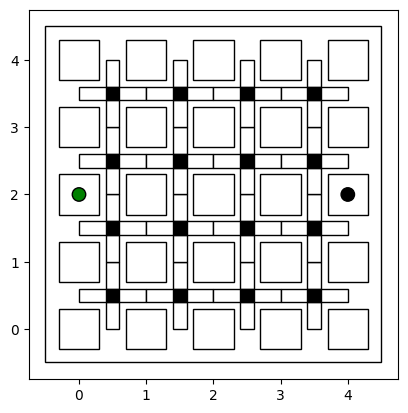

100%|█████████▉| 498/500 [00:53<00:00, 13.56it/s]

In [ ]:
# Module 5: Main Game Loop
"""
Module 5: Main Game Loop
Purpose: Runs the Quoridor game with an MCTS-based AI opponent.
Key Features:
- Initializes the game with a specified board size and number of walls.
- Alternates between AI moves (using MCTS) and player input (for testing).
- Visualizes the game state and policy after each move.
- Terminates when a player wins or the game reaches 50 moves.
"""
def main():
    game = QuoridorGame(board_size=5, total_walls=3)
    config = {
        'draw_discount': 0.0,
        'C': 2,
        'n_searches': 500,
    }
    mcts = MCTSSearch(game, config)
    state = game.new_game()
    current_player = 0
    empty_policy = np.zeros((3, game.board_size, game.board_size))
    visualize_policy(empty_policy, empty_policy, state, current_player)
    while True:
        policy = mcts.run_search(state, current_player)
        action = np.unravel_index(np.argmax(policy), policy.shape)
        action_type, row, col = action
        new_state = game.apply_action(state, (action_type, row, col), current_player)
        visualize_policy(policy, game.get_available_actions(state, current_player), new_state, current_player)
        state = new_state
        is_terminal, _, value = game.check_game_status(state, current_player)
        if is_terminal:
            print(f"Game over: Player {current_player} {'wins' if value == 1 else 'draws'}")
            break
        current_player = 1 - current_player

if __name__ == "__main__":
    main()